## Data import

This section will also serve as a seasonality and stationarity evaluation section, as well as analysing possible structural break analysis

In [1]:
import pandas as pd

data = pd.read_csv('raw_data.csv', parse_dates=["Date"])
data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m")
data["Inland Consumption"] = pd.to_numeric(data["Inland Consumption"])


data = data.set_index("Date")
data = data.asfreq("MS")

data

,Inland Consumption
Date,
2014-01-01,1392.0
2014-02-01,1301.0
2014-03-01,1064.0
2014-04-01,954.0
2014-05-01,777.0
...,...
2024-09-01,438.0
2024-10-01,710.0
2024-11-01,1233.0


In [2]:
import plotly
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')


In [3]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index,
                         y=data['Inland Consumption'],
                         mode='lines'))

fig.update_layout(title="Romania's Inland Gas Consumption",
                  xaxis_title='Date',
                  title_x = 0.5,
                  yaxis_title='Million cubic meters',
                  template='plotly_white')
            
fig.show()

## Evaluating stationarity and seasonality

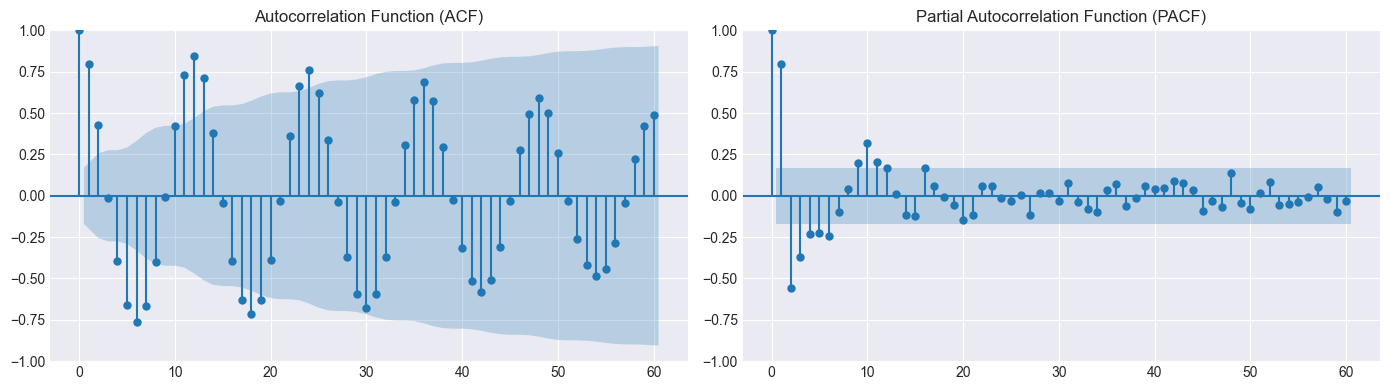

In [4]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Autocorrelation plot
plot_acf(data['Inland Consumption'], ax=axes[0], lags=60)
axes[0].set_title("Autocorrelation Function (ACF)")

# Partial Autocorrelation plot
plot_pacf(data['Inland Consumption'], ax=axes[1], lags=60, method="ywm")
axes[1].set_title("Partial Autocorrelation Function (PACF)")

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


Monthly seasonality is present in the data, as we can see from the ACF plot. The PACF plot shows a significant spike at lag 1, which suggests that the series is likely an AR(1) process.

In [5]:
# Definging monthly seasonal plot
# ==============================================================================
def plot_seasonal(data):
    fig = go.Figure()
    
    data['year'] = data.index.year
    data['month'] = data.index.month
    year_list = data['year'].unique().tolist()

    # Loop through each year and plot the data
    for idx, year in enumerate(year_list):
        df = data[data['year'] == year][['month', 'Inland Consumption']]
        # Sort by month (just in case)
        df = df.sort_values(by='month')
        # Create a trace for each year
        color_palette = px.colors.qualitative.Pastel
        trace = go.Scatter(
            x=df['month'],  # Use the month as the x-axis
            y=df['Inland Consumption'],  # Use "Inland Consumption" as the y-axis
            line=dict(width=2, color=color_palette[idx % len(color_palette)]),  # Dynamic color for each year
            mode='lines',
            name=str(year),  # Use the year as the legend name
            legendgroup=str(year),
            showlegend=True
        )

        # Add the trace to the figure
        fig.add_trace(trace)

    # Update layout for better visualization
    fig.update_layout(
        title="Seasonality Plot of Romania's Inland Gas Consumption",
        title_x = 0.5,
        xaxis_title="Month",
        yaxis_title="Million cubic meters",
        legend_title="Year",
        template="plotly_white",
        width=1000,
        height=600,
        xaxis=dict(
            tickmode='array',  # Use custom tick labels
            tickvals=list(range(1, 13)),  # Months 1 to 12
            ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']  # Month names
        )
    )

    # Show the plot
    fig.show()

# Call the function with your DataFrame
plot_seasonal(data)

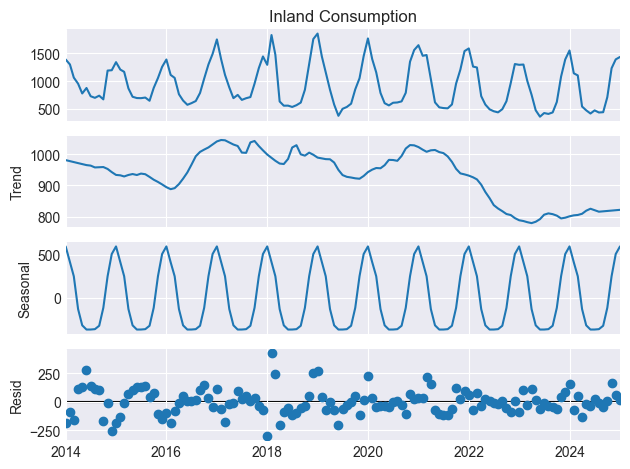

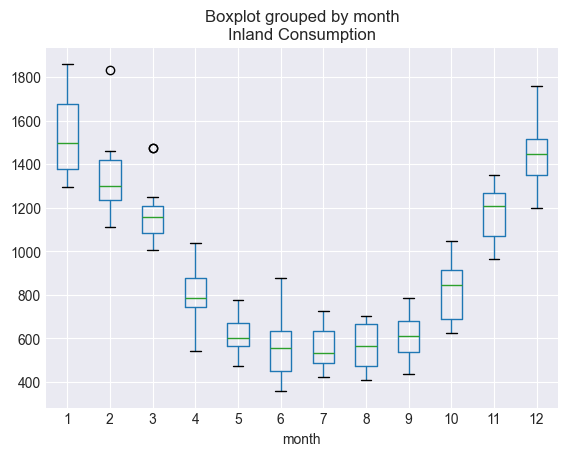

Date
2014-01-01    980.861548
2014-02-01    977.666764
2014-03-01    974.471979
2014-04-01    971.277195
2014-05-01    968.082411
                 ...    
2024-09-01    816.974699
2024-10-01    818.162490
2024-11-01    819.350282
2024-12-01    820.538073
2025-01-01    821.725864
Freq: MS, Name: trend, Length: 133, dtype: float64


In [6]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Assuming your DataFrame 'data' is already loaded and prepared

# Seasonal Decomposition
decomposition = seasonal_decompose(data["Inland Consumption"], model="additive", extrapolate_trend='freq') #or multiplicative if needed
decomposition.plot()
plt.show()

trend=decomposition.trend


# Monthly boxplots to see seasonal variation
data['month'] = data.index.month
data.boxplot(column='Inland Consumption', by='month')
plt.show()

print(trend)

In [7]:
from arch.unitroot import ADF, DFGLS, PhillipsPerron, KPSS

adf = ADF(data['Inland Consumption'], trend='ct', lags=12)

print(adf.summary().as_text())

# We already know that the data is non-stationary, so we will apply differencing

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.374
P-value                         0.868
Lags                               12
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.04 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [8]:
#Differentiate monthly seasonality for the first order
data_diff = data.diff(periods=12).dropna()
data_diff

#Differentiate sesaonality for the second order
data_diff2 = data_diff.diff(periods=12).dropna()
data_diff2

,Inland Consumption,year,month
Date,,,
2016-01-01,97.0,0.0,0.0
2016-02-01,-5.0,0.0,0.0
2016-03-01,-213.0,0.0,0.0
2016-04-01,-19.0,0.0,0.0
2016-05-01,-8.0,0.0,0.0
...,...,...,...
2024-09-01,63.0,0.0,0.0
2024-10-01,101.0,0.0,0.0
2024-11-01,32.0,0.0,0.0


In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_diff.index,
                         y=data_diff['Inland Consumption'],
                         mode='lines'))


fig.update_layout(title="First Order Differencing",
                  xaxis_title='Date',
                  title_x = 0.5,
                  yaxis_title='',
                  template='plotly_white')

fig.show()

In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_diff2.index,
                         y=data_diff2['Inland Consumption'],
                         mode='lines'))


fig.update_layout(title="Second Order Differencing",
                  xaxis_title='Date',
                  title_x = 0.5,
                  yaxis_title='',
                  template='plotly_white')

fig.show()

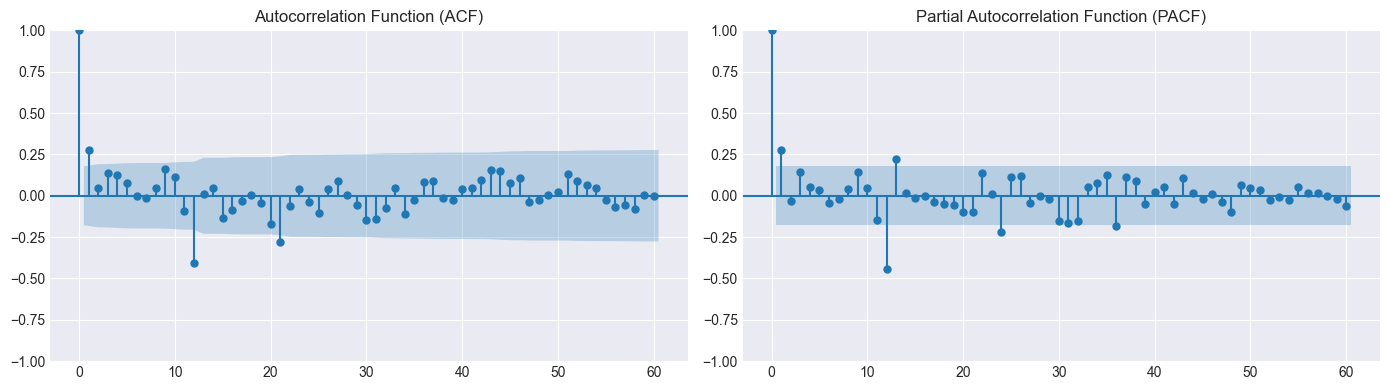

In [23]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Autocorrelation plot
plot_acf(data_diff['Inland Consumption'], ax=axes[0], lags=60)
axes[0].set_title("Autocorrelation Function (ACF)")

# Partial Autocorrelation plot
plot_pacf(data_diff['Inland Consumption'], ax=axes[1], lags=60, method="ywm")
axes[1].set_title("Partial Autocorrelation Function (PACF)")

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

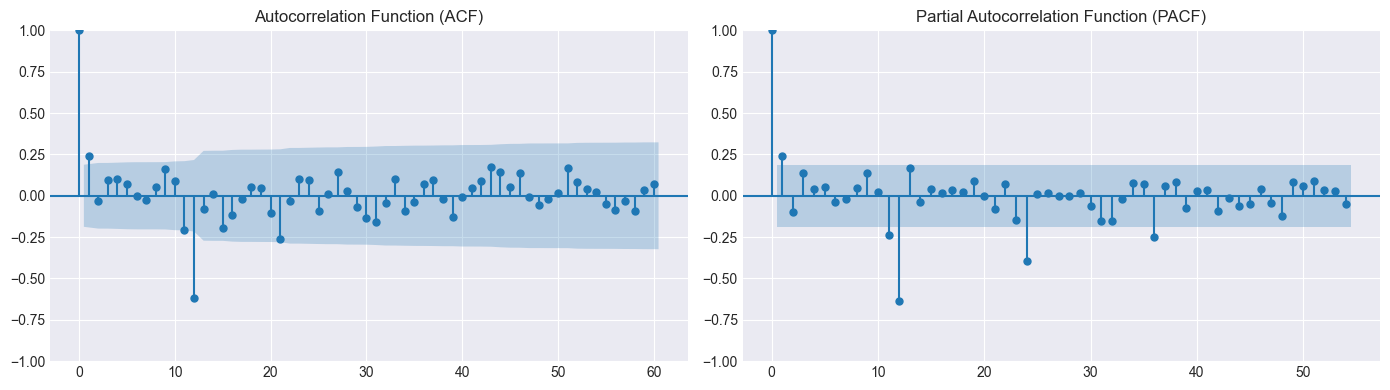

In [25]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Autocorrelation plot
plot_acf(data_diff2['Inland Consumption'], ax=axes[0], lags=60)
axes[0].set_title("Autocorrelation Function (ACF)")

# Partial Autocorrelation plot
plot_pacf(data_diff2['Inland Consumption'], ax=axes[1], lags=54, method="ywm")
axes[1].set_title("Partial Autocorrelation Function (PACF)")

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

In [9]:
adf = ADF(data_diff2['Inland Consumption'], trend='ct')

print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.125
P-value                         0.006
Lags                               12
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.06 (1%), -3.46 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [10]:
# Create a date range from 2014-01 to 2025-01 with monthly frequency
date_range = pd.date_range(start='2014-01-01', end='2025-01-01', freq='MS')

# Initialize a DataFrame with the date range as the index
crisis_events = pd.DataFrame(index=date_range)

# Define the crisis events and their durations in separate columns
crisis_events['COVID-19'] = 0
crisis_events['European Energy Crisis'] = 0
crisis_events['Russian-Ukraine Conflict'] = 0

crisis_events.loc['2020-03-01':'2023-05-01', 'COVID-19'] = 1
crisis_events.loc['2021-07-01':'2023-08-01', 'European Energy Crisis'] = 1
crisis_events.loc['2022-02-01':, 'Russian-Ukraine Conflict'] = 1

print(crisis_events)

            COVID-19  European Energy Crisis  Russian-Ukraine Conflict
2014-01-01         0                       0                         0
2014-02-01         0                       0                         0
2014-03-01         0                       0                         0
2014-04-01         0                       0                         0
2014-05-01         0                       0                         0
...              ...                     ...                       ...
2024-09-01         0                       0                         1
2024-10-01         0                       0                         1
2024-11-01         0                       0                         1
2024-12-01         0                       0                         1
2025-01-01         0                       0                         1

[133 rows x 3 columns]


We will proceed to feature engineering, the first one being trigonometric functions of the seasonality

In [11]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(periods):
    return FunctionTransformer(lambda x: np.sin(x / periods * 2 * np.pi))

def cos_transformer(periods):
    return FunctionTransformer(lambda x: np.cos(x / periods * 2 * np.pi))

In [ ]:
trig_df = pd.DataFrame()
trig_df.index = data.index

trig_df['month'] = data.index.month

trig_df['Cons_sin'] = sin_transformer(12).fit_transform(trig_df[['month']])
trig_df['Cons_cos'] = cos_transformer(12).fit_transform(trig_df[['month']])


print(trig_df)

            month      Cons_sin      Cons_cos
Date                                         
2014-01-01      1  5.000000e-01  8.660254e-01
2014-02-01      2  8.660254e-01  5.000000e-01
2014-03-01      3  1.000000e+00  6.123234e-17
2014-04-01      4  8.660254e-01 -5.000000e-01
2014-05-01      5  5.000000e-01 -8.660254e-01
...           ...           ...           ...
2024-09-01      9 -1.000000e+00 -1.836970e-16
2024-10-01     10 -8.660254e-01  5.000000e-01
2024-11-01     11 -5.000000e-01  8.660254e-01
2024-12-01     12 -2.449294e-16  1.000000e+00
2025-01-01      1  5.000000e-01  8.660254e-01

[133 rows x 3 columns]


In [13]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=trig_df.index,
                         y=trig_df['Cons_sin'],
                         mode='lines',
                         name='Sine')
                         )


fig.add_trace(go.Scatter(x=trig_df.index,
                         y=trig_df['Cons_cos'],
                         mode='lines',
                         name='Cosine')
                         )

fig.update_layout(title="Trigonometric functions of Romania's Inland Gas Consumption",
                  xaxis_title='Date',
                  title_x = 0.5,
                  yaxis_title='',
                  template='plotly_white')
            
fig.show()

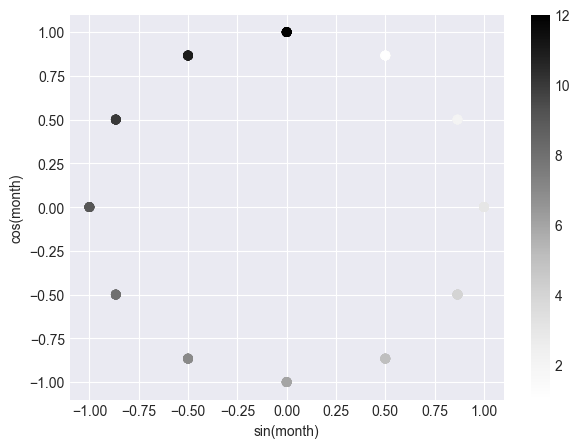

In [14]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(trig_df["Cons_sin"], trig_df["Cons_cos"], c=trig_df["month"])
ax.set(
    xlabel="sin(month)",
    ylabel="cos(month)",
)
_ = fig.colorbar(sp)

In [15]:
# Ziwot andrews test on raw data
from statsmodels.tsa.stattools import zivot_andrews

za_result = zivot_andrews(data['Inland Consumption'], trim=0.15)
print(f"Test Statistic: {za_result[0]}")
print(f"P-value: {za_result[1]}")
print(f"Critical Values: {za_result[2]}")
print(f"Break Point: {za_result[3]}")

Test Statistic: -3.235515738486232
P-value: 0.8246472790397906
Critical Values: {'1%': np.float64(-5.27644), '5%': np.float64(-4.81067), '10%': np.float64(-4.56618)}
Break Point: 13


In [16]:
# Ziwot andrews test on trend of decomposed seasonal data
za_result_trend = zivot_andrews(trend, trim=0.15)
print(f"Test Statistic: {za_result_trend[0]}")
print(f"P-value: {za_result_trend[1]}")
print(f"Critical Values: {za_result_trend[2]}")
print(f"Break Point: {za_result_trend[3]}")

Test Statistic: -3.744527601861898
P-value: 0.5168644676465869
Critical Values: {'1%': np.float64(-5.27644), '5%': np.float64(-4.81067), '10%': np.float64(-4.56618)}
Break Point: 13


Breakpoints in raw data: [95, 100, 105, 110, 130, 133]


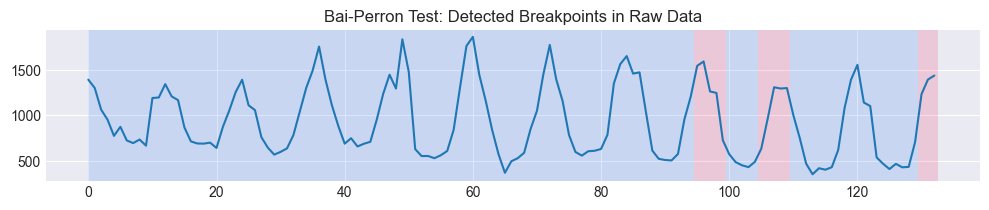

Breakpoints in trend data: [10, 30, 60, 95, 100, 133]


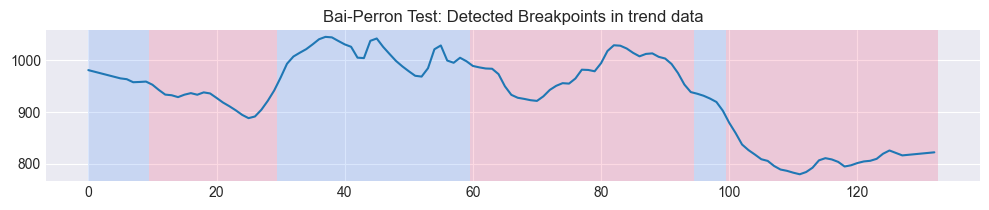

In [30]:
import ruptures as rpt
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and 'Inland Consumption' is the column of interest
series = data['Inland Consumption'].values

# Perform the Bai-Perron test
model = "l2"  # Model for the cost function
algo = rpt.Binseg(model=model).fit(series)
result = algo.predict(n_bkps=5)  # Number of breakpoints to detect

# Display results
print(f"Breakpoints in raw data: {result}")

# Plot the results
rpt.display(series, result)
plt.title("Bai-Perron Test: Detected Breakpoints in Raw Data")
plt.show()

series_trend = trend.values

# Perform the Bai-Perron test
model = "l2"  # Model for the cost function
algo = rpt.Binseg(model=model).fit(series_trend)
result = algo.predict(n_bkps=5)  # Number of breakpoints to detect

# Display results
print(f"Breakpoints in trend data: {result}")

# Plot the results
rpt.display(series_trend, result)
plt.title("Bai-Perron Test: Detected Breakpoints in trend data")
plt.show()


In [19]:
exog = pd.concat([trig_df, crisis_events], axis=1)
exog = exog.drop(columns=['month'])
exog['Date'] = exog.index

print(exog)

                Cons_sin      Cons_cos  COVID-19  European Energy Crisis  \
2014-01-01  5.000000e-01  8.660254e-01         0                       0   
2014-02-01  8.660254e-01  5.000000e-01         0                       0   
2014-03-01  1.000000e+00  6.123234e-17         0                       0   
2014-04-01  8.660254e-01 -5.000000e-01         0                       0   
2014-05-01  5.000000e-01 -8.660254e-01         0                       0   
...                  ...           ...       ...                     ...   
2024-09-01 -1.000000e+00 -1.836970e-16         0                       0   
2024-10-01 -8.660254e-01  5.000000e-01         0                       0   
2024-11-01 -5.000000e-01  8.660254e-01         0                       0   
2024-12-01 -2.449294e-16  1.000000e+00         0                       0   
2025-01-01  5.000000e-01  8.660254e-01         0                       0   

            Russian-Ukraine Conflict       Date  
2014-01-01                         0 

In [21]:
exog.to_csv('d:/#Programare/Py VSC/LightGBM/Data/exog_data.csv')